# Logistic Regression and Sentiment analysis 

In this assignment you will implement and experiment with various feature engineering techniques in the context of Logistic Regression models for Sentiment classification of movie reviews.

1. Logistic regression, linear algebra, and derivatives.

2. Read lexicons of positive and negative sentiment words.

3. Implement overall positive and negative lexicon count features.

4. Implement per-lexicon-word count features.

5. Implement document length feature.

6. Implement deictic features.

7. Pre-processing for negation.

8. Plot learning curves.

9. Open bonus points.

10. Analysis of results.

We will use the LR model implemented in sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Sean Devlin

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your name above.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells). 
4. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX and download a PDF version *wikipedia.pdf* showing the code and the output of all cells, and save it in the same folder that contains the notebook file *wikipedia.ipynb*.
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing we will see when grading!
7. Submit **both** your PDF and notebook on Canvas.
8. Make sure your your Canvas submission contains the correct files by downloading it after posting it on Canvas.

## Theory (10p + 5p + 5p + 5p + 5p)

1. Let $\mathbf{w} = [0.3, -0.4]$, $\mathbf{x} = [1.2, 0.5]$, and $b = -0.66$. Compute the following:
    - The Euclidean (L2) norms $||\mathbf{w}||$ and $||\mathbf{x}||$.
    - The logit score $z = \mathbf{w}^T \mathbf{x} + b$.
    - The probability $p(y = 1 | \mathbf{x})$ that $\mathbf{x}$ is positive, as computed by a binary logistic regression model with parameters $\mathbf{w}, b$.
    - Keeping $\mathbf{w}$ and $\mathbf{x}$ fixed, find the value of $b$ such that the probability above becomes 0.5.

2. Prove that the derivative of the sigmoid function can be written as $\sigma'(z) = \sigma(z) \cdot (1 - \sigma(z))$.

3. Using the chain rule of differentiation, prove that $\displaystyle\frac{\delta \sigma(\mathbf{w}^T\mathbf{x} +b)}{\delta \mathbf{w}} = \sigma(\mathbf{w}^T\mathbf{x} +b) \cdot (1 - \sigma(\mathbf{w}^T\mathbf{x} +b)) \cdot \mathbf{x}$.

4. Subtracting a constant $c$ from all logit score does not change the probabilities computed by
softmax, i.e., $softmax(z_1 − c, z_2 − c, ..., z_K − c) = softmax(z_1, z_2, ..., z_K)$

5. Show the gradient of the objective function $J(w_1, w_2) = 2w_1^2 + 3w_2^2 -4w_1 +12w_2 + 15$. Use the gradient the parameters $w_1$ and $w_2$ that minimize $J$.


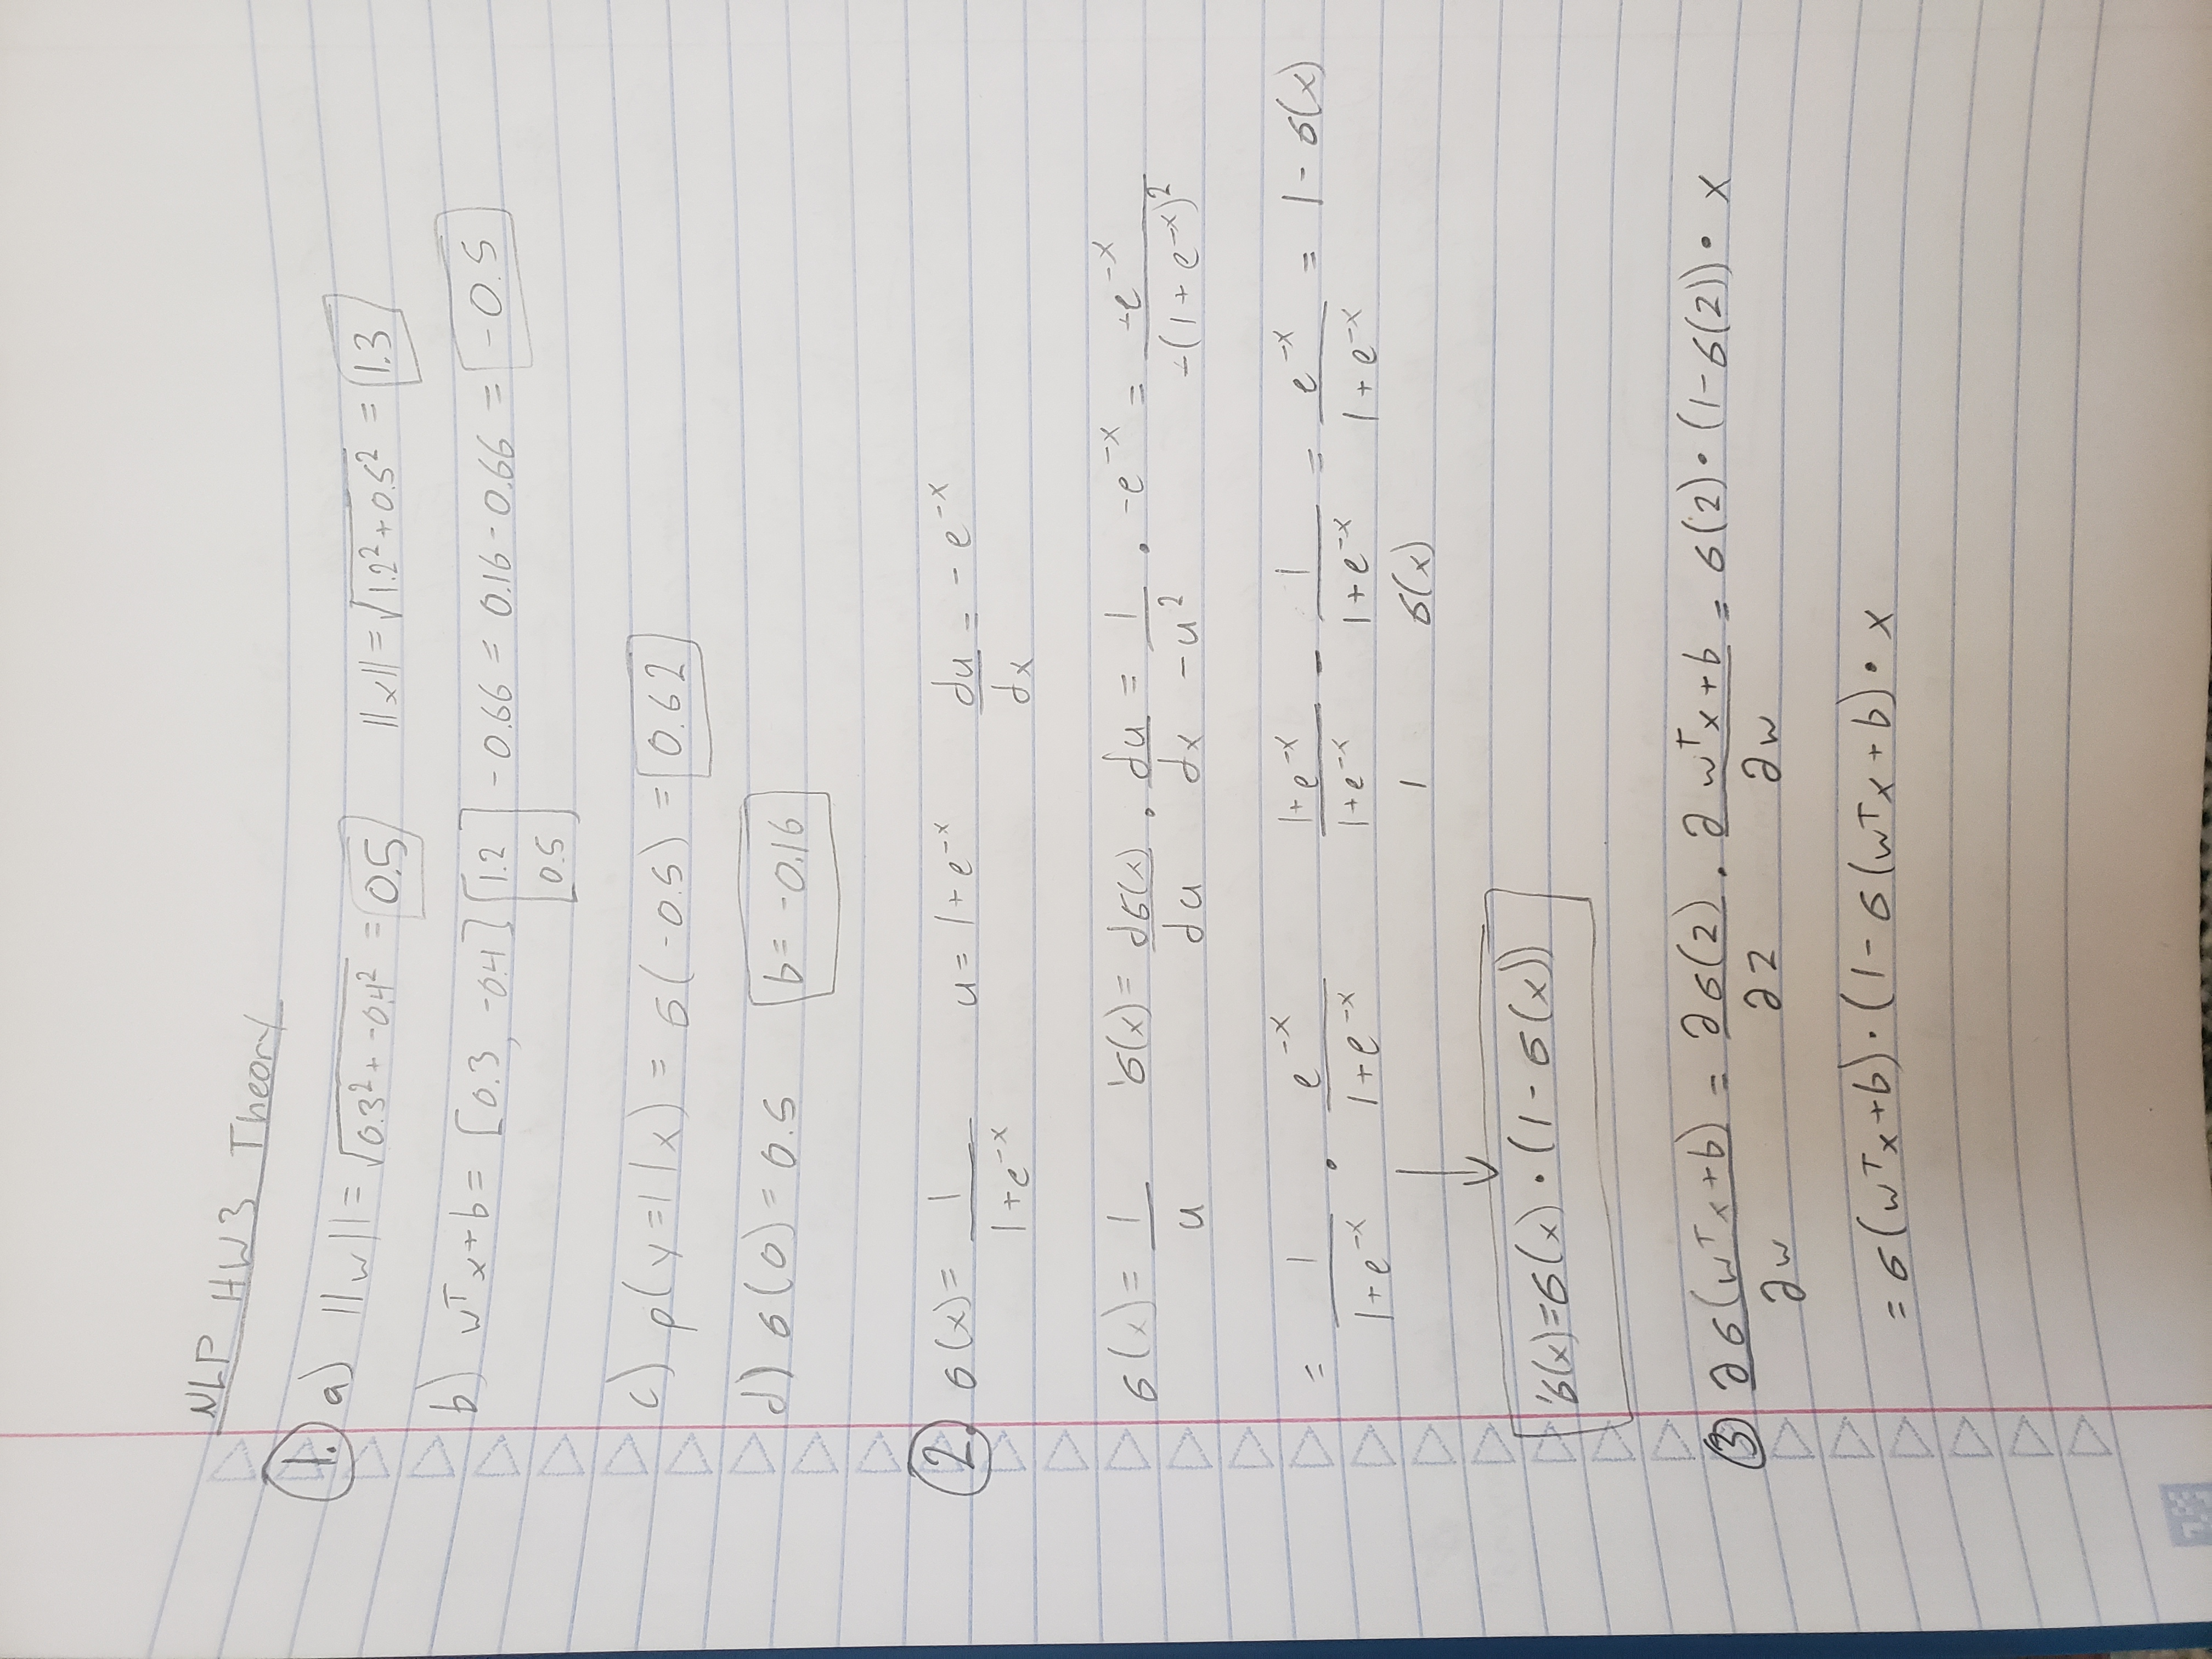

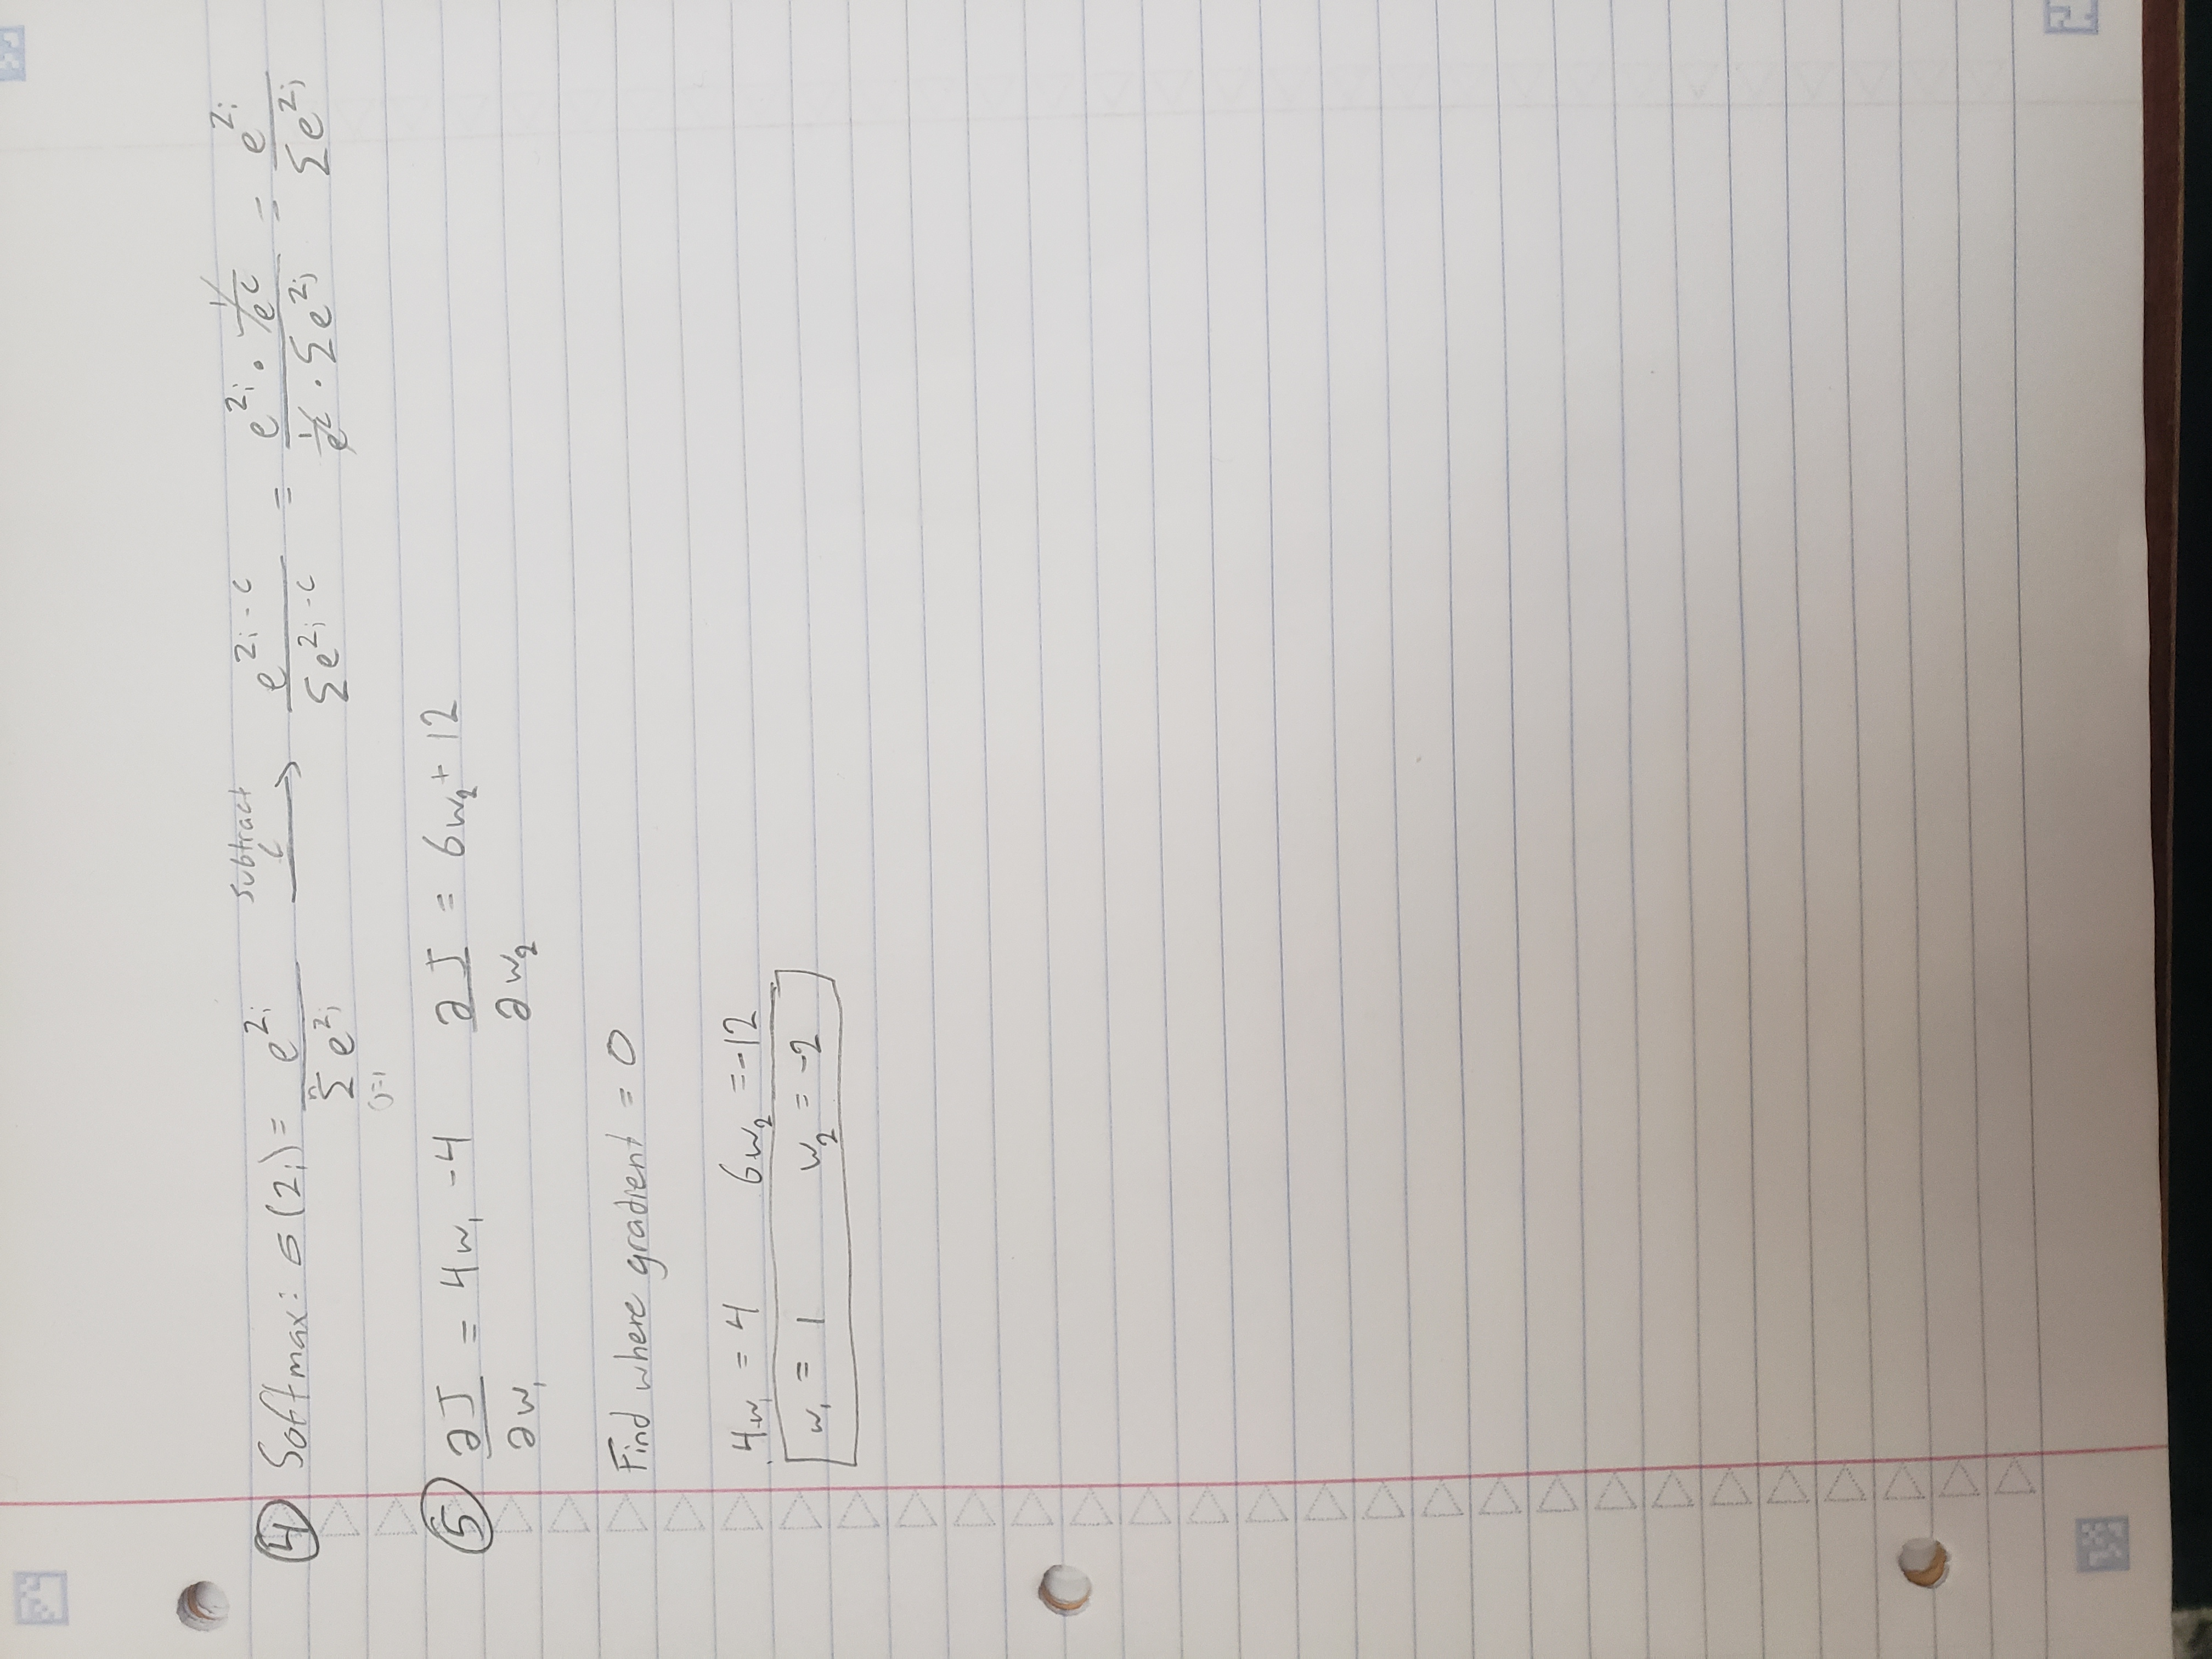

## From documents to feature vectors
This section illustratess the prototypical components of machine learning pipeline for an NLP task, in this case document classification:

1. Read document examples (train, devel, test) from files with a predefined format:
    - assume one document per line, usign the format "\<label\> \<text\>".

2. Tokenize each document:
    - using a spaCy tokenizer.

3. Feature extractors:
    - so far, just words.

4. Process each document into a feature vector:
    - map document to a dictionary of feature names.
    - map feature names to unique feature IDs.
    - each document is a feature vector, where each feature ID is mapped to a feature value (e.g. word occurences).

In [176]:
import spacy
from spacy.lang.en import English
from scipy import sparse
from sklearn.linear_model import LogisticRegression

In [177]:
# Create spaCy tokenizer.
spacy_nlp = English()

def spacy_tokenizer(text):
    tokens = spacy_nlp.tokenizer(text)
    
    return [token.text for token in tokens]

In [178]:
def read_examples(filename):
    X = []
    Y = []
    with open(filename, mode = 'r', encoding = 'utf-8') as file:
        for line in file:
            [label, text] = line.rstrip().split(' ', maxsplit = 1)
            X.append(text)
            Y.append(label)
    return X, Y

In [179]:
def word_features(tokens):
    feats = {}
    for word in tokens:
        feat = 'WORD_%s' % word
        if feat in feats:
            feats[feat] +=1
        else:
            feats[feat] = 1
    return feats

In [180]:
def add_features(feats, new_feats):
    for feat in new_feats:
        if feat in feats:
            feats[feat] += new_feats[feat]
        else:
            feats[feat] = new_feats[feat]
    return feats

This function tokenizes the document, runs all the feature extractors on it and assembles the extracted features into a dictionary mapping feature names to feature values. It is important that feature names do not conflict with each other, i.e. **different features should have different names**. Each document will have its own dictionary of features and their values.

In [181]:
def docs2features(trainX, feature_functions, tokenizer):
    examples = []
    count = 0
    for doc in trainX:
        feats = {}

        tokens = tokenizer(doc)
        
        for func in feature_functions:
            add_features(feats, func(tokens))

        examples.append(feats)
        count +=1
        
        if count % 100 == 0:
            print('Processed %d examples into features' % len(examples))
    
    return examples

In [182]:
# This helper function converts feature names to unique numerical IDs.

def create_vocab(examples):
    feature_vocab = {}
    idx = 0
    for example in examples:
        for feat in example:
            if feat not in feature_vocab:
                feature_vocab[feat] = idx
                idx += 1
                
    return feature_vocab

In [183]:
# This helper function converts a set of examples from a dictionary of feature names to values representation
# to a sparse representation of feature ids to values. This is important because almost all feature values will
# be 0 for most documents and it would be wasteful to save all in memory.

def features_to_ids(examples, feature_vocab):
    new_examples = sparse.lil_matrix((len(examples), len(feature_vocab)))
    for idx, example in enumerate(examples):
        for feat in example:
            if feat in feature_vocab:
                new_examples[idx, feature_vocab[feat]] = example[feat]
                
    return new_examples

In [184]:
# Evaluation pipeline for the Logistic Regression classifier.

def train_and_test(trainX, trainY, devX, devY, feature_functions, tokenizer):
    # Pre-process training documents. 
    trainX_feat = docs2features(trainX, feature_functions, tokenizer)

    # Create vocabulary from features in training examples.
    feature_vocab = create_vocab(trainX_feat)
    print('Vocabulary size: %d' % len(feature_vocab))

    trainX_ids = features_to_ids(trainX_feat, feature_vocab)
    
    # Train LR model.
    lr_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 1000)
    lr_model.fit(trainX_ids, trainY)
    
    # Pre-process test documents. 
    devX_feat = docs2features(devX, feature_functions, tokenizer)
    devX_ids = features_to_ids(devX_feat, feature_vocab)
    
    # Test LR model.
    print('Accuracy: %.3f' % lr_model.score(devX_ids, devY))

In [185]:
import os

datapath = '../data'

train_file = os.path.join(datapath, 'imdb_sentiment_train.txt')
trainX, trainY = read_examples(train_file)

dev_file = os.path.join(datapath, 'imdb_sentiment_dev.txt')
devX, devY = read_examples(dev_file)

# Specify features to use.
features = [word_features]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Vocabulary size: 28692


/home/sdev/projects/NLPHomework/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Accuracy: 0.839


## Feature engineering

Evaluate LR model performance when adding positive and negative lexicon features. We will be using Bing Liu's sentiment lexicons from https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

### Read the positive and negative sentiment lexicons (10p)

There should be 2006 entries in the positive lexicon and 4783 entries in the positive lexicon.

In [186]:
def read_lexicon(filename):
    lexicon = set()
    with open(filename, mode = 'r', encoding = 'ISO-8859-1') as file:
        for line in file:
            if line[0] != ';' and line[0] != '\n':
                lexicon.add(line.strip())

    
    return lexicon

lexicon_path = '../data/bliu'

poslex_file = os.path.join(lexicon_path, 'positive-words.txt')
neglex_file = os.path.join(lexicon_path, 'negative-words.txt')

poslex = read_lexicon(poslex_file)
neglex = read_lexicon(neglex_file)


print(len(poslex), 'entries in the positive lexicon.')
print(len(neglex), 'entries in the negative lexicon.')

2006 entries in the positive lexicon.
4783 entries in the negative lexicon.


### Use the lexicons to create two lexicon features (15p)

- A feature 'POSLEX' whose value indicates how many tokens belong to the positive lexicon.
- A feature 'NEGLEX' whose value indicates how many tokens belong to the negative lexicon.

In [187]:
def two_lexicon_features(tokens):
    feats = {'POSLEX': 0, 'NEGLEX': 0}
    # YOUR CODE HERE
    for token in tokens:
        if token in poslex:
            feats['POSLEX'] += 1
        if token in neglex:
            feats['NEGLEX'] += 1
    
    
    
    return feats

Evaluate the LR model using the two new lexicon features. Expected accuracy is around 83.8%.

In [188]:
# Specify features to use.
features = [word_features, two_lexicon_features]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Vocabulary size: 28694


/home/sdev/projects/NLPHomework/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Accuracy: 0.838


### Create a separate feature for each word that appears in each lexicon (20p)

- If a word from the positive lexicon (e.g. 'like') appears N times in the document (e.g. 5 times), add a positive lexicon feature 'POSLEX_word' for that word that is associated that value (e.g. {'POSLEX_like' : 5}.
- Similarly, if a word from the negative lexicon (e.g. 'dislike') appears N times in the document (e.g. 5 times), add a negative lexicon feature 'NEGLEX_word' for that word that is associated that value (e.g. {'NEGLEX_dislike' : 5}.

In [189]:
def lexicon_features(tokens):
    feats = {}
    # YOUR CODE HERE
    # Assume the positive and negative lexicons are available in poslex and neglex, respectively.
    for token in tokens:
        feature = ''
        if token in poslex:
            feature = f"POSLEX_{token}"
        if token in neglex:
            feature = f"NEGLEX_{token}"

        #update dictionary
        if feature != '':
            if feature in feats:
                feats[feature] += 1
            else:
                feats[feature] = 1

    
    
    return feats

Evaluate the LR model using the new per-lexicon word features. Expected accuracy is arpund 83.9%.

In [190]:
# Specify features to use.
features = [word_features, lexicon_features]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Vocabulary size: 31721


/home/sdev/projects/NLPHomework/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Accuracy: 0.839


### Add document length feature (10p)

Add a feature 'DOC_LEN' whose value is the natural logarithm of the document length (use *math.log* to compute logarithms).

In [191]:
import math
def len_feature(tokens):
    feat = {'DOC_LEN': math.log(len(tokens))}

    return feat

Evaluate the LR model using the new document length feature. Expected accuracy is around 84.0%.

In [192]:
# Specify features to use.
features = [word_features, lexicon_features, len_feature]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Vocabulary size: 31722


/home/sdev/projects/NLPHomework/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Accuracy: 0.837


### Add deictic features (15p)

Add a feature 'DEICTIC_COUNT' that counts the number of 1st and 2nd person pronouns in the document.

In [193]:
def deictic_feature(tokens):
    pronouns = set(('i', 'my', 'me', 'we', 'us', 'our', 'you', 'your'))
    count = 0
    
    # YOUR CODE HERE
    for token in tokens:
        if token in pronouns:
            count += 1
    
    
    
    return {'DEICTIC_COUNT': count}

Evaluate the LR model using the deictic features. Expected accuracy is around 84.2%.

In [194]:
# Specify features to use.
features = [word_features, lexicon_features, len_feature, deictic_feature]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Vocabulary size: 31723


/home/sdev/projects/NLPHomework/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Accuracy: 0.841


Let's try without the word features. Expected accuracy is around 80.4%.

In [195]:
# Specify features to use.
features = [lexicon_features, len_feature, deictic_feature]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Vocabulary size: 3031


/home/sdev/projects/NLPHomework/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Accuracy: 0.805


## Pre-processing for negation (10p)

Preprocess the tokens to account for negation, as explained on slide 36 in the LR lecture, and integrate in the model that uses `word_features`, `lexicon_features`, `len_feature`, and `deictic_feature`.

- Pre-process the text for all negation words contained in the lexicon `../data/negation_words.txt`.
- Need to rewrite the sentiment lexicon features such that whenever modified by a negation word, a positive sentiment word is counted as negative, i.e. 'NOT_like' will be a negative sentiment token. The prefix 'NOT_' should be added irrespective of the actual negative word used, e.g. 'not', 'never', etc.
  * For bonus points, you can also run evaluations where the actual negative word is used as a prefix, e.g. 'never' before 'like' would lead to a feature called 'NEVER_like'.
- Train and evaluate the performance of the new model.

In [196]:
# YOUR CODE HERE
negations = read_lexicon("../data/negation_words.txt")

def negation_features(tokens):
    feats = {}

    prev_negation = False
    for token in tokens:
        #flag negations
        if token in negations:
            prev_negation = True
            continue
        
        feature = ''
        if (token in poslex) and (prev_negation == True):
            feature = f"NOT_{token}"
            prev_negation = False
        elif token in poslex:
            feature = f"POSLEX_{token}"
        elif token in neglex:
            feature = f"NEGLEX_{token}"

        #update dictionary
        if feature != '':
            if feature in feats:
                feats[feature] += 1
            else:
                feats[feature] = 1

    return feats


#Test new feature
features = [negation_features]
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Vocabulary size: 3551
Processed 100 examples into features


/home/sdev/projects/NLPHomework/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Accuracy: 0.805


## [Bonus] Compute learning curve (15p)

Select the best performing model and plot its accuracy vs. number of training examples. Vary the number of training examples by selecting for each class the first N examples in the file, where $N \in \{50, 100, 150, 250, 350, 450, 550, 650, 750\}$. For example, the first 50 positive examples would be inb `X[:50]`, whereas the first 50 negative examples would be in `X[750:800]`. 

In [197]:
# YOUR CODE HERE






## Bonus points ##
Anything extra goes here. For example, can you do feature engineering or hyper-parameter tuning such that accuracy gets over 85%? The larger the gain in accuracy, the more bonus points awarded.
- Evaluate the impact of other features, such as the presence of exclamation points, or replacing word features with lemma features.

- Determine the importance of counts by using binary word features instead of count features, i.e. does the word appear or not in the document, instead of how many times.

- Simple feature selection: use only features that appear at least K times in the training data (try K = 3, K = 5).
  * Also evaluate the impact of feature selection when usign smaller valeus for the `C` hyper-parameter for L2 regularization.

- Look at the mistakes the model made (error analysis) and see if you can design new features to address the more common mistakes.

- Replace the spaCy tokenizer with the tiktoken BPE tokenizer and see impact on performance (accuracy).

In [198]:
# YOUR CODE HERE





## Analysis (10 + 10p)
Include an analysis of the results that you obtained in the experiments above.

**Error analysis**: Do some basic error analysis where you try to explain the mistakes that the best model made and provide ideas for possible features that would alleviate these mistakes.

**Interpretability**: From each class of features take 2 features that you think should be strongly correlated with the positive or negative label, and determine if the model learned a corresponding parameter that correctly expresses this correlation. For example, the feature 'WORD_loved' is expected to be very correlated with the positive label, as such the model should learn a corresponding large positive weight.
  - *Hint: for this, you may consider using the `coef_` attribute of the LogisticRegression class.*

In [199]:
test_file = os.path.join(datapath, 'imdb_sentiment_test.txt')
testX, testY = read_examples(test_file)

In [200]:
features = [word_features, lexicon_features, len_feature, deictic_feature]

# Pre-process training documents. 
trainX_feat = docs2features(trainX, features, spacy_tokenizer)

# Create vocabulary from features in training examples.
feature_vocab = create_vocab(trainX_feat)
print('Vocabulary size: %d' % len(feature_vocab))

trainX_ids = features_to_ids(trainX_feat, feature_vocab)

# Train LR model.
lr_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 1000)
lr_model.fit(trainX_ids, trainY)

# Pre-process test documents. 
testX_feat = docs2features(testX, features, spacy_tokenizer)
testX_ids = features_to_ids(testX_feat, feature_vocab)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features
Vocabulary size: 31723


/home/sdev/projects/NLPHomework/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Processed 400 examples into features
Processed 500 examples into features
Processed 600 examples into features
Processed 700 examples into features
Processed 800 examples into features
Processed 900 examples into features
Processed 1000 examples into features
Processed 1100 examples into features
Processed 1200 examples into features
Processed 1300 examples into features
Processed 1400 examples into features
Processed 1500 examples into features


In [203]:
import numpy as np

#find incorrectly classified reviews
y_hat = lr_model.predict(testX_ids)
incorrect = np.where(y_hat != np.array(testY), testX, None)
mask = (incorrect != None)

# for label, pred, text in zip(np.array(testY)[mask], y_hat[mask], incorrect[mask]):
#     print(f"Label: {label}, Prediction: {pred}, Text: {text}")


Label: pos, Prediction: neg
Text: Brain of Blood starts as Abdul Amir (Reed Hadley) the leader of a country called Kahlid is close to death because of cancer, however if he dies Kahlid will tear itself apart without anyone to lead them so doctor Robert Nigserian (Grant Williams) & one of Amir's devotees Mohammed (Zandor Vorkov) have devised a plan to take Amir's dead body to America where mad scientist Dr. Lloyd Trenton (Kent Taylor) will transplant his brain into a fresh body & with a bit of plastic surgery no-one will ever know he was even dead. Things don't go according to plan though as when the time comes to transplant Amir's brain Trenton's freak assistant Gor (John Bloom) brings a dead body of someone that fell from a balcony, Trenton needed a strong fit living body & since there's no more time he decides to use Gor's body as a temporary stop-gap until another more suitable one can be found. Unfortunately when Amir wakes up in his new body he's not very happy at what he sees, I mean would you be if you found out your brain was inside a badly burned freak?
Also known as Brain Damage, The Brain, The Creature's Revenege & The Undying Brain this cheapo exploitation flick was produced & directed by the one & only Al Adamason & quite frankly I'm offended at the pathetic 1.5 rating Brain of Blood has on the IMDb, personally I think it's terrific fun in a so bad it's good sort of way. The highly entertaining script by Kane W. Lynn & Joe Van Rodgers is as loopy & silly as they come from sloppy blood soaked brain transplants to crazed mad scientists, from 7 foot tall acid scarred freaks who play with toy cars to 4 foot tall midget medical assistant's, from basement dungeons to rooftop chases, from car crashes to assassination's, kidnaps to screaming scantily clad women, from Regina Carrol's hair-do which should get it's own mention during the opening credits to teenage girls imprisoned in the basement for blood to a laugh-out-loud hilarious ending which includes some deep meaningful speech! It's all here & Brain of Blood has quality cheese stamped all over it, if your a fan of bad low budget exploitation flicks with a sense of fun then this film should be right at the top of your list of 'must see' films. Despite it's lowly 1.5 rating I am proud to admit that I liked Brain of Blood a lot, I thought it was an absolute hoot to watch, it slows down a bit at the end with a few too many shots of people wandering around doing nothing in particular but until that point it had moved along like a rocket, at only 85 minutes it's relatively short, it's difficult to second guess the barmy plot & I just think it's loads of campy fun.
This is director Adamson's masterpiece as far as I'm concerned along with Dracula vs. Frankenstein (1971) which he made a year before this. Those who have seen an Adamson film before will know about the none existent production values, cheap special effects & cardboard sets & that all adds to the fun, this film manages that fine between incompetence & seriousness to create a memorable viewing experience. I love the opening shot of Kahlid which is obviously just a photo of the Taj Mahal in India complete with statuesque people in the foreground! Regina Carrol's hair seems to be a separate entity on it's own, it seems to change styles between shots & is frankly horrendous, don't get me started about her make-up job either that she must apply with a a paint sprayer! There is another hilarious moment when we see Amir's body has been transported to America wrapped in what looks like ordinary tin foil, why is the question I asked myself, why!? The effects are variable, there's a terrible looking fake spider, Gor's burned make-up job is pretty bad although there is a surprisingly gory brain removal which is actually quite impressive.
The budget for Brain of Blood must have been practically none existent, I must admit I thought Trenton's lab was quite good with various computers & medical instruments although the rest of the film looks cheap & nasty. The production values are low, the music was taken from another film Beast of Blood (1971) & the acting is awful but in a campy fun sort of way.
Brain of Blood may have the best title for an exploitation film ever & as far as I'm concerned it's a highly entertaining piece of nonsense that I had a great time watching & laughing at. They just don't/can't/won't make them like this anymore, impossible to recommend to anyone looking for a good film but bad movie lovers should enjoy it. I liked it, but then again I'm just weird.

This review is pretty understandable for the model to have classified incorrectly, because the author enjoys the movie seemingly because it is bad. This model is not complex enough to recognize the concept of a "fun bad" movie.

Label: neg, Prediction: pos
Text: I tried to love this movie. I really did. Kevin Bacon plays a cerebral palsy victim who is befriended by a 10-year-old girl whose fantasies of digging to China, flying away in a balloon, and so on, are her way of coping with a dreary existence. I admit I did fast-forward through one of the scenes in which the two of them share friendship and simple pleasures while soulful piano music plays in the background. Okay, three or four of those type scenes. Maybe nine or ten. Okay, okay, it was fourteen. But I did sit and watch most of them.

This review is negative because of the over-the-top positivity of the movie. It is also quite short, which means the model does not have much a lot of positive or negative words to work with.

Both of these were misclassified because of author's use of sarcasm, which is very difficult for a simple model like this to detect. Perhaps making the features more heavily weighted when they appear in the review could help the model distinguish between a potentially sarcastic intro and the author's true feelings.



In [202]:
feats = np.array(list(feature_vocab.keys())).reshape(-1, 1)
coeffs = np.array(lr_model.coef_[0]).reshape(-1, 1)

feature_coeffs = np.hstack((feats, coeffs))
feature_coeffs = feature_coeffs[np.argsort(feature_coeffs[:,1])]

#I expect that "NEGLEX_hated" will have a low value and "DOC_LEN" will be high, since negative reviews seem to be shorter
output = feature_coeffs[np.where(np.isin(feature_coeffs[:,0], ["NEGLEX_hated", "DOC_LEN"]))]

print(output)

[['DOC_LEN' '-0.0275650314960753']
 ['NEGLEX_hated' '-0.12817700848084929']]


I was correct about "NEGLEX_hated" having a strong negative value, but it appears that longer reviews actually tend to have a slight negative correlation.